In [102]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import string
import warnings
warnings.filterwarnings('ignore')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from collections import defaultdict
from wordcloud import WordCloud
from sklearn.metrics import confusion_matrix,f1_score
import nltk
nltk.download('stopwords')
  

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\monika\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [103]:
data = pd.read_csv("D:/MachineLearning/spam detection/spam.csv", encoding='ISO 8859-1')

In [104]:
data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [105]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
v1            5572 non-null object
v2            5572 non-null object
Unnamed: 2    50 non-null object
Unnamed: 3    12 non-null object
Unnamed: 4    6 non-null object
dtypes: object(5)
memory usage: 217.7+ KB


In [106]:
data.fillna(" ", inplace=True)
data['text_message'] = data['v2'] + data['Unnamed: 2'] + data['Unnamed: 3'] + data['Unnamed: 4']

In [107]:
data1 = data[['v1', 'text_message']]
data1.dropna(inplace=True)
data['v1'].value_counts()

ham     4825
spam     747
Name: v1, dtype: int64

### Now we preprocess the data-

  1.remove all extra whitespaces.
  2.lower case all the letters.
  3.remove punctuations.
  4.tokenize eac message.
  5.remove stopwords like 'the','in' etc that doesn't add meaning to the message.
  6.stem each word to it's root word e.g go,goes,going,gone becomes go.
  7.remove single letter words (i,a etc)
  8.encode ham=0 and spam=1.

In [131]:
data1['text_message'] = data1['text_message'].str.strip()
data1['text_message'] = data1['text_message'].str.lower()
data1['text_message'] = data1['text_message'].str.replace("[^a-zA-Z#]", " ")

In [132]:
#remove punctuation
punc = string.punctuation
table = str.maketrans('','',punc)
data1['text_message']=data1['text_message'].apply(lambda x: x.translate(table))

In [133]:
data1['word_tokens'] = data1.apply(lambda x: x['text_message'].split(' '), axis=1)

In [134]:
data1['cleaned_text'] = data1.apply(lambda x: [word for word in x['word_tokens'] if word not in stopwords.words('english')], axis=1)

In [135]:
# stemming
ps = PorterStemmer()
data1['stemmed']= data1.apply(lambda x: [ps.stem(word) for word in x['cleaned_text']],axis=1)

In [136]:
# remove single 3 letter words
data1['final_text'] = data1.apply(lambda x: ' '.join([word for word in x['stemmed'] if len(word)>3]),axis=1)

In [137]:
 # label encoding ham=0 and spam=1
data1.loc[data1['v1']=='ham','v1']=0
data1.loc[data1['v1']=='spam','v1']=1

In [138]:
# divide the set in training and test
from sklearn.model_selection import train_test_split
X,X_test,y,y_test = train_test_split(data1.loc[:,'text_message':],data1['v1'],test_size=0.2)

In [139]:
# Now we'll create a vocabulary for the training set with word count
vocab=defaultdict(int) 
for text in X['final_text'].values:
    for element in text.split(' '):
        vocab[element]+=1

Text(0.5,1,'HAM')

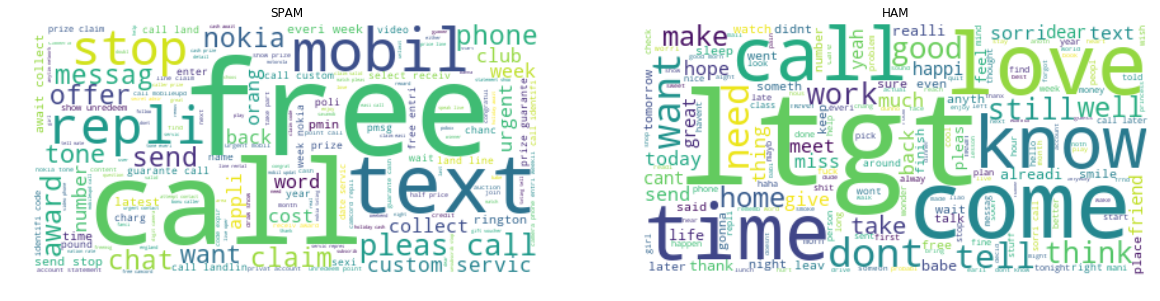

In [140]:
# Now we look at the types of words in ham and spam. We plot wordclouds for both
ham_text=' '.join(X.loc[y==0,'final_text'].values)
ham_wordcloud = WordCloud(background_color='white',max_words=2000).generate(ham_text)
spam_text=' '.join(X.loc[y==1,'final_text'].values)
spam_wordcloud = WordCloud(background_color='white',max_words=2000).generate(spam_text)
plt.figure(figsize=[20,30])
plt.subplot(1,2,1)
plt.imshow(spam_wordcloud,interpolation='bilinear')
plt.title('SPAM')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(ham_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('HAM')

In [141]:

# We see that call, free text, claim etc are the most used words in spam.
# tokenize the text for further calculations
X['tokenized_final_text']=X['final_text'].str.split(' ')
X_test['tokenized_final_text']=X_test['final_text'].str.split(' ')

In [142]:
# document frequency(number of docs containing word w) and Inverse document frequency(measures rarity of each word)
df={}
for k in vocab.keys():
    df[k]=np.sum(X['tokenized_final_text'].apply(lambda x: 1 if k in x else 0))
    
# Now we'll calculate the idf score of each word
idf = {k:1+np.log((1+X.shape[0]/(1+v))) for k,v in df.items()}

In [143]:
# tf * idf
for elem in vocab.keys():
    X[elem]= X['tokenized_final_text'].apply(lambda x: x.count(elem)*idf[elem] if elem in x else 0)
for elem in vocab.keys():
    X_test[elem]= X_test['tokenized_final_text'].apply(lambda x: x.count(elem)*idf[elem] if elem in x else 0)

In [144]:
y=y.astype('int')
y_test = y_test.astype('int')

In [145]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(max_depth=70, random_state=3)
rf.fit(X.iloc[:,6:],y)
confusion_matrix(y,rf.predict(X.iloc[:,6:]))

array([[3871,    1],
       [  45,  540]], dtype=int64)

In [146]:
confusion_matrix(y_test,rf.predict(X_test.iloc[:,6:]))

array([[951,   2],
       [ 35, 127]], dtype=int64)

In [147]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X.iloc[:,6:],y)
confusion_matrix(y,lr.predict(X.iloc[:,6:]))

array([[3872,    0],
       [   1,  584]], dtype=int64)

In [148]:
confusion_matrix(y_test,lr.predict(X_test.iloc[:,6:]))

array([[949,   4],
       [ 15, 147]], dtype=int64)

In [149]:
lr

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [150]:
#accuracy and f1 score of random forest
print("RANDOM FOREST ")
print("F1 SCORE", f1_score(y_test,rf.predict(X_test.iloc[:,6:])))
print ("ACCURACY SCORE", rf.score(X_test.iloc[:,6:], y_test))

RANDOM FOREST 
F1 SCORE 0.872852233676976
ACCURACY SCORE 0.9668161434977578


In [151]:
#accuracy and f1 score of logistic regression
print("LOGISTIC REGRESSION")
print("F1 SCORE", f1_score(y_test,lr.predict(X_test.iloc[:,6:])))
print("ACCURACY SCORE", lr.score(X_test.iloc[:,6:], y_test))

LOGISTIC REGRESSION
F1 SCORE 0.9392971246006391
ACCURACY SCORE 0.9829596412556054



So in this case logistic regression works better than random forest.

Positive coefficients try to shift the predictions towards spam as the sigmoid will tend to 1 and thus making spam prediction while the negative features contribute to ham. Let's see some of these features.

In [152]:
ham_20 = np.argsort(lr.coef_)[0][:20]
spam_20 = np.argsort(lr.coef_)[0][-20:]

In [153]:

features = X.iloc[:,6:].columns
print('------------SPAM FEATURES------------')
for elem in spam_20:
    print(features[elem])
    
print('------------HAM FEATURES------------')
for elem in ham_20:
    print(features[elem])

------------SPAM FEATURES------------
urgent
fanci
rington
adult
call
lost
freemsg
pmsg
prize
mobil
freeringtonerepli
barbi
messag
claim
voicemail
freephon
filthi
servic
ringtonek
cost
------------HAM FEATURES------------
later
ltgt
billion
much
said
isnt
home
cant
that
work
problem
morn
happi
reach
dont
tell
watch
type
wait
didnt


In [154]:
len(lr.coef_[0])

5389


These results make some sense as prize,claim,urgent,credit,sexi,rington are some features that we don't use s much in ur day to day messages but they do appear frequently in spams. Also we notice a lot of numbers in spam features.Maybe we can convert all numbers to a single string 'digit' next time and then apply the classifier. This might improve the accuracy a bit or atleast it'll reduce some dimensions. Punctuations can also be a good indicator for spam as one would expect a lot of exclamations and question marks in spams.

Now that we understand the methodology for spam detection we'll try a shortcut for this approach i.e using scikit-learn's TfIdfvectorizer to perform all of above steps after preprocessing to lead to similar result.

In [155]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf=TfidfVectorizer()

In [156]:
X_train = tf.fit_transform(X['final_text'])
y_train = y
X_test1 = tf.transform(X_test['final_text'])
y_test1 = y_test

In [157]:
lr1 = LogisticRegression()
lr1.fit(X_train, y_train)
print("F1 SCORE", f1_score(y_test1,lr1.predict(X_test1)))
print("ACCURACY SCORE", lr1.score(X_test1,y_test1))

F1 SCORE 0.8231046931407943
ACCURACY SCORE 0.9560538116591928


In [158]:
confusion_matrix(y_train,lr1.predict(X_train))

array([[3862,   10],
       [ 175,  410]], dtype=int64)

In [160]:
# Looking at some of the messages in X_test and their classification.
# We see that obivous spams are caught but some slip by e.g 22. It's difficult to detect such messages as it looks 
# like a normal conversation except at few words which completely changes the meaning.
# Maybe bi-grams will help as unigram doesn't capture the full meaning of the messages. Even then our solution
#works fine

for i in range(30):
    if lr.predict(X_test.iloc[i,6:])[0]==0:
        print(i,'     ',X_test.iloc[i,0],'---------','Not a spam')
    else:
        print(i,'     ',X_test.iloc[i,0],'---------','Spam!!!!!!')
        

ValueError: Expected 2D array, got 1D array instead:
array=[0. 0. 0. ... 0. 0. 0.].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.